# Covid-19 Forecasting using an RNN

The goal of this notebook is very simple: Generate additional features from the Covid19-global-forecasting dataset and feed it into an RNN. The RNN will take as inputs:
    -number of cases for 6 days
    -number of fatalities for 6 days
                  as outputs:
    -number of cases for the 7th day
    -number of fatalities for the 7th day

Update version 5: Submission pipeline fixed - score: 3.09681
Update version 6: New RNN architecture with two separate branches for each output.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid19-global-forecasting-week-2/train.csv
/kaggle/input/covid19-global-forecasting-week-2/submission.csv
/kaggle/input/covid19-global-forecasting-week-2/test.csv


In [2]:
train_df = gpd.read_file("/kaggle/input/covid19-global-forecasting-week-2/train.csv")
train_df["Country_Region"] = [country_name.replace("'","") for country_name in train_df["Country_Region"]]
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry
0,1,,Afghanistan,2020-01-22,0.0,0.0,None
1,2,,Afghanistan,2020-01-23,0.0,0.0,None
2,3,,Afghanistan,2020-01-24,0.0,0.0,None
3,4,,Afghanistan,2020-01-25,0.0,0.0,None
4,5,,Afghanistan,2020-01-26,0.0,0.0,None


I create a new dataframe where I will only store 6-day trends for each location with the resulting numbers on the 7th day. The time periods extracted do not overlap on purpose.

In [3]:
trend_df = pd.DataFrame(columns={"infection_trend","fatality_trend","expected_cases","expected_fatalities"})

In [4]:
#Just getting rid of the first days to have a multiple of 7
#Makes it easier to generate the sequences
train_df = train_df.query("Date>'2020-01-29' and Date<='2020-03-18'")

with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
    for country in train_df.Country_Region.unique():
        for province in train_df.query("Country_Region=='"+country+"'").Province_State:
            province_df = train_df.query("Country_Region=='"+country+"' and Province_State=='"+province+"'")
            for i in range(0,len(province_df)-7,7):

                infection_trend = [float(x) for x in province_df[i:i+6].ConfirmedCases.values]
                fatality_trend = [float(x) for x in province_df[i:i+6].Fatalities.values]
                expected_cases = float(province_df.iloc[i+7].ConfirmedCases)
                expected_fatalities = float(province_df.iloc[i+7].Fatalities)
                                            
                trend_df = trend_df.append({"infection_trend":infection_trend,
                                 "fatality_trend":fatality_trend,
                                 "expected_cases":expected_cases,
                                 "expected_fatalities":expected_fatalities},ignore_index=True)
        pbar.update(1)

100%|██████████| 173/173 [14:29<00:00,  5.03s/it]


Shuffling the dataframe to make sure we have a bit of everything in our training and validation set.

In [5]:
trend_df["input"] = [np.asarray([np.array(trends["infection_trend"]),np.asarray(trends["fatality_trend"])]) for idx,trends in trend_df.iterrows()]

In [6]:
trend_df = shuffle(trend_df)
trend_df.head()

,expected_cases,expected_fatalities,fatality_trend,infection_trend,input
7107,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
2109,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
19707,93.0,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[91.0, 91.0, 91.0, 91.0, 93.0, 93.0]","[[91.0, 91.0, 91.0, 91.0, 93.0, 93.0], [1.0, 1..."
53526,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
1010,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."


Only keeping 2000 sequences where the number of cases stays at 0, as there were way too many of these samples in our dataset.

In [7]:
i=0
y=0
temp_df = pd.DataFrame(columns={"infection_trend","fatality_trend","expected_cases","expected_fatalities","input"})
for idx,row in trend_df.iterrows():
    if sum(row.infection_trend)>0:
        temp_df = temp_df.append(row)
    else:
        if i<2000:
            temp_df = temp_df.append(row)
            i+=1
trend_df = temp_df

In [8]:
trend_df[:20]

,fatality_trend,expected_cases,infection_trend,expected_fatalities,input
7107,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
2109,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
19707,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",93.0,"[91.0, 91.0, 91.0, 91.0, 93.0, 93.0]",1.0,"[[91.0, 91.0, 91.0, 91.0, 93.0, 93.0], [1.0, 1..."
53526,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
1010,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
8703,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
33127,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
66357,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
15427,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",279.0,"[215.0, 224.0, 239.0, 250.0, 261.0, 267.0]",0.0,"[[215.0, 224.0, 239.0, 250.0, 261.0, 267.0], [..."
10151,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",3.0,"[1.0, 1.0, 1.0, 2.0, 2.0, 2.0]",0.0,"[[1.0, 1.0, 1.0, 2.0, 2.0, 2.0], [0.0, 0.0, 0...."


Splitting my dataset - 90% for training and 10% for validation

In [9]:
sequence_length = 6
training_percentage = 0.9
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [10]:
X_train = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in training_df["input"]]),(training_item_count,2,sequence_length))).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [11]:
X_test = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in validation_df["input"]]),(validation_item_count,2,sequence_length))).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_cases"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

## Build the model

The model is very simple in terms of architecture. The only difference from what could traditionally be seen is that it has two outputs so we can have two different losses (one for the expected number of cases and for the expected number of fatalities).

In [12]:
sequence_length = 6
input_layer = Input(shape=(2,sequence_length))
x = layers.SimpleRNN(64,return_sequences=True)(input_layer)
x = layers.SimpleRNN(32)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.2)(x)
cases = layers.Dense(1, activation="relu",name="cases")(x)
fatalities = layers.Dense(1, activation="relu", name="fatalities")(x)
model = Model(input_layer, [cases,fatalities])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 6)]       0                                            
__________________________________________________________________________________________________
simple_rnn (SimpleRNN)          (None, 2, 64)        4544        input_1[0][0]                    
__________________________________________________________________________________________________
simple_rnn_1 (SimpleRNN)        (None, 32)           3104        simple_rnn[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           2112        simple_rnn_1[0][0]               
______________________________________________________________________________________________

In [13]:
sequence_length = 6
input_layer = Input(shape=(2,sequence_length))
main_rnn_layer = layers.SimpleRNN(128, return_sequences=True)(input_layer)

rnn_c = layers.SimpleRNN(32)(main_rnn_layer)
rnn_f = layers.SimpleRNN(32)(main_rnn_layer)

dense_c = layers.Dense(64)(rnn_c)
dropout_c = layers.Dropout(0.2)(dense_c)

dense_f = layers.Dense(64)(rnn_f)
dropout_f = layers.Dropout(0.2)(dense_f)

cases = layers.Dense(1, activation="linear",name="cases")(dropout_c)
fatalities = layers.Dense(1, activation="linear", name="fatalities")(dropout_f)
model = Model(input_layer, [cases,fatalities])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2, 6)]       0                                            
__________________________________________________________________________________________________
simple_rnn_2 (SimpleRNN)        (None, 2, 128)       17280       input_2[0][0]                    
__________________________________________________________________________________________________
simple_rnn_3 (SimpleRNN)        (None, 32)           5152        simple_rnn_2[0][0]               
__________________________________________________________________________________________________
simple_rnn_4 (SimpleRNN)        (None, 32)           5152        simple_rnn_2[0][0]               
____________________________________________________________________________________________

In [14]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=["mse","mse"], optimizer='adam')

In [15]:
history = model.fit(X_train, [Y_cases_train, Y_fatalities_train], 
          epochs = 100, 
          batch_size = 64, 
          validation_data=(X_test,  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Train on 26716 samples, validate on 2969 samples
Epoch 1/100
26716/26716 [==============================] - 6s 217us/sample - loss: 33459748.3898 - cases_loss: 33367074.0000 - fatalities_loss: 47681.3438 - val_loss: 36803822.7167 - val_cases_loss: 36361868.0000 - val_fatalities_loss: 39650.4492
Epoch 2/100
26716/26716 [==============================] - 2s 93us/sample - loss: 32456936.2252 - cases_loss: 32384342.0000 - fatalities_loss: 28985.1484 - val_loss: 35327732.1095 - val_cases_loss: 34912116.0000 - val_fatalities_loss: 19544.4492
Epoch 3/100
26716/26716 [==============================] - 2s 91us/sample - loss: 30855966.4319 - cases_loss: 30998798.0000 - fatalities_loss: 14499.8447 - val_loss: 33395557.1493 - val_cases_loss: 32999560.0000 - val_fatalities_loss: 8961.3340
Epoch 4/100
26716/26716 [==============================] - 2s 92us/sample - loss: 28925150.5068 - cases_loss: 28880590.0000 - fatalities_loss: 5675.5557 - val_loss: 31016280.3577 - val_cases_loss: 30639226.0000 - 

### Performance during training

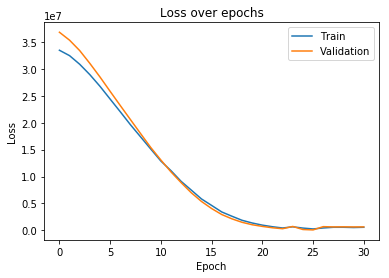

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

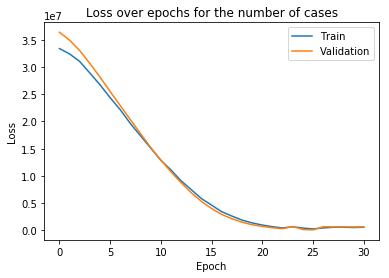

In [17]:
plt.plot(history.history['cases_loss'])
plt.plot(history.history['val_cases_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

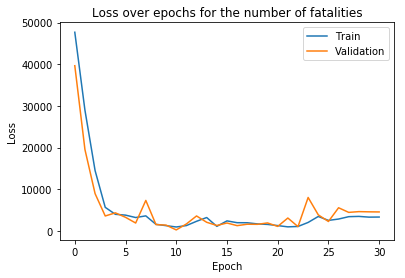

In [18]:
plt.plot(history.history['fatalities_loss'])
plt.plot(history.history['val_fatalities_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

We can quickly check the quality of the predictions... One thing is clear, there is room for improvement!

In [19]:
model.load_weights("best_model.h5")

In [20]:
predictions = model.predict(X_test)

In [21]:
display_limit = 50
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )

[[5. 7. 7. 7. 7. 7.]
 [0. 0. 0. 0. 0. 0.]]
Expected cases: 9.0  Prediction: -43.19273 Expected fatalities: 0.0  Prediction: 1.2519051
[[65596. 65914. 66337. 66907. 67103. 67217.]
 [ 2641.  2682.  2727.  2761.  2803.  2835.]]
Expected cases: 67466.0  Prediction: 63051.63 Expected fatalities: 2902.0  Prediction: 2525.785
[[0. 0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 0. 0.]]
Expected cases: 5.0  Prediction: -7.3274198 Expected fatalities: 0.0  Prediction: 1.8961648
[[91. 91. 91. 91. 93. 93.]
 [ 1.  1.  1.  1.  1.  1.]]
Expected cases: 93.0  Prediction: 129.68626 Expected fatalities: 1.0  Prediction: 2.6994233
[[4. 4. 4. 4. 4. 4.]
 [0. 0. 0. 0. 0. 0.]]
Expected cases: 4.0  Prediction: -0.44475603 Expected fatalities: 0.0  Prediction: 0.8025308
[[48206. 54406. 56249. 58182. 59989. 61682.]
 [ 1310.  1457.  1596.  1696.  1789.  1921.]]
Expected cases: 62442.0  Prediction: 61587.496 Expected fatalities: 2144.0  Prediction: 2155.5122
[[0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]]
Expected cases: 1.0  Predicti

### Apply the model on this existing data

The following functions will be used to get the 6 previous days from a given date, predict the number of cases and fatalities, before iterating again. Therefore, it will use the prediction for the next day as part of the data for the one afterwards.

In [22]:
#Will retrieve the number of cases and fatalities for the past 6 days from the given date
def build_inputs_for_date(country, province, date, df):
    start_date = date - timedelta(days=6)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    df = df.query("Country_Region=='"+country+"' and Province_State=='"+province+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    input_data = np.reshape(np.asarray([df["ConfirmedCases"],df["Fatalities"]]),(2,sequence_length)).astype(np.float32)
    
    return input_data

In [23]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_region(country, province, df):
    begin_prediction = "2020-03-19"
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d")
    end_prediction = "2020-04-30"
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(country, province, date, df)
        result = model.predict(np.array([input_data]))
        
        #just ensuring that the outputs is above 0
        #Get the absolute value for the number of cases
        result[0] = np.absolute(result[0])
        result[1][result[1] < 0] = 0.0
        df = df.append({"Country_Region":country, 
                        "Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},ignore_index=True)
    return df

In [24]:
copy_df = train_df
with tqdm(total=len(list(copy_df.Country_Region.unique()))) as pbar:
    for country in copy_df.Country_Region.unique():
        for province in copy_df.query("Country_Region=='"+country+"'").Province_State.unique():
            copy_df = predict_for_region(country, province, copy_df)
        pbar.update(1)

100%|██████████| 173/173 [22:13<00:00,  7.71s/it]


In [25]:
copy_df.query("Country_Region=='France' and Date>'2020-03-19'")

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,geometry
19051,NaN,French Guiana,France,2020-03-20,18,2,None
19052,NaN,French Guiana,France,2020-03-21,20,2,None
19053,NaN,French Guiana,France,2020-03-22,79,3,None
19054,NaN,French Guiana,France,2020-03-23,580,7,None
19055,NaN,French Guiana,France,2020-03-24,4485,0,None
...,...,...,...,...,...,...,...
19475,NaN,,France,2020-04-26,63361,2666,None
19476,NaN,,France,2020-04-27,63234,2786,None
19477,NaN,,France,2020-04-28,63052,2526,None
19478,NaN,,France,2020-04-29,63361,2666,None


In [26]:
test_df = gpd.read_file("/kaggle/input/covid19-global-forecasting-week-2/test.csv")
test_df.head()

,ForecastId,Province_State,Country_Region,Date,geometry
0,1,,Afghanistan,2020-03-19,None
1,2,,Afghanistan,2020-03-20,None
2,3,,Afghanistan,2020-03-21,None
3,4,,Afghanistan,2020-03-22,None
4,5,,Afghanistan,2020-03-23,None


Just need to do this little trick to extract the relevant date and the forecastId and add that to the submission file.

In [27]:
submission_df = pd.DataFrame(columns=["ForecastId","ConfirmedCases","Fatalities"])
for idx, row in test_df.iterrows():
    #Had to remove single quotes because of countries like Cote D'Ivoire for example
    country_region = row.Country_Region.replace("'","").strip(" ")
    province_state = row.Province_State.replace("'","").strip(" ")
    item = copy_df.query("Country_Region=='"+country_region+"' and Province_State=='"+province_state+"' and Date=='"+row.Date+"'")
    submission_df = submission_df.append({"ForecastId":row.ForecastId,
                                          "ConfirmedCases":int(item.ConfirmedCases.values[0]),
                                          "Fatalities":int(item.Fatalities.values[0])},
                                         ignore_index=True)

In [28]:
submission_df.sample(20)

,ForecastId,ConfirmedCases,Fatalities
60,61,15303,0
7262,7263,63361,2666
1782,1783,8640,0
6471,6472,19270,0
10936,10937,10368,17
1994,1995,1090,8
918,919,18324,619
7265,7266,63361,2666
7635,7636,57516,1826
10291,10292,63080,3328


In [29]:
submission_df.to_csv("submission.csv",index=False)

### Of course, this notebook still requires a lot of work but I thought I would release a first version anyway, mainly to help anyone who could be working on a similar pipeline. I will try to update this notebook with an improved model itself in the following iterations.

### If you found this notebook helpful, please give it an upvote. It will be greatly appreciated!